# Balancing dataset in Machine Learning

- oversampling
- undersampling
- class weight
- threshold

In this tutorial, I would use the `imbalanced-learn` library, which is part of the contrib packages of `scikit-learn`

In [1]:
import pandas as pd

df = pd.read_csv('https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/classification/data/recipes.csv')
df['is_indian'] = (df.cuisine == "indian").astype(int)
df.head()

,cuisine,id,ingredient_list,is_indian
0,greek,10259,"romaine lettuce, black olives, grape tomatoes,...",0
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, gr...",0
2,filipino,20130,"eggs, pepper, salt, mayonaise, cooking oil, gr...",0
3,indian,22213,"water, vegetable oil, wheat, salt",1
4,indian,13162,"black pepper, shallots, cornflour, cayenne pep...",1


In [2]:
df['is_indian'].value_counts()

0    36771
1     3003
Name: is_indian, dtype: int64

As input features, I use the matrix of TFIDF values given by the list of ingredients

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(df.ingredient_list)

X = matrix
y = df['is_indian']

Now split the dataset into training and test sets. I set the size of the test to the 30% of the whole dataset. Then I print the number of samples in each set, by using the `Counter()` function, contained in the `Collections` package

In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 2114})
Testing target statistics: Counter({0: 11044, 1: 889})


# Model building 

Now I will train and test a Decision Tree algorithm, using the different balancing technique. I define a function, called `build_and_test()`, which will be invoked by each balancing technique. This function receives as input the training input `X_tr`, and the testing input `X_te`, the training output `y_tr`, the testing output `y_te`, the `class_weight` parameter, which will be used by the class weight technique and the `threshold` parameter, which will be used by the threshold technique.

In addition, the `build_and_test()` function executes the following operations:

- build and plot the Principal Component Analysis (PCA) which shows the class distribution
- buiild and fit the model
- test the model by calculating the evaluation metrics
- plot the metrics using `scikit-plot` library
- print a classification report
- return metrics for a final combined plot

Plotted metrics include Precision/Recall, [Cumulative Gain](http://mlwiki.org/index.php/Cumulative_Gain_Chart) and lift curve


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from scikitplot.metrics import plot_roc, plot_precision_recall, plot_cumulative_gain, plot_lift_curve

from numpy import argmax
import numpy as np

def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    
    # Build and plot PCA
    pca = PCA(n_components=2)
    pca.fit(X_tr.toarray())
    X_pca = pca.transform(X_tr.toarray())
    
    plt.scatter(X_pca[:, 0], X_pca[:,1], c=y_tr, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
    plt.show()
    
    # Build and fit the model
    if class_weight:
        model = DecisionTreeClassifier(class_weight=class_weight)
    else:
        model = DecisionTreeClassifier()
    model.fit(X_tr, y_tr)
    
    # Test the model
    y_pred = model.predict(X_te)
    print('Precision score: %s' % precision_score(y_te, y_pred))
    print('Recall score: %s' % recall_score(y_te, y_pred))
    print('F1-score score: %s' % f1_score(y_te, y_pred))
    print('Accuracy score: %s' % accuracy_score(y_te, y_pred))
    
    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:,1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximises the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    
    # Plot metrics
    plot_roc(y_te, y_score)
    plt.show()
    
    plot_precision_recall(y_te, y_score)
    plt.show()
    
    plot_cumulative_gain(y_te, y_score)
    plt.show()
    
    plot_lift_curve(y_te, y_score)
    plt.show()
    
    # Print a classification report
    print(classification_report(y_te, y_pred))
    
    return roc_auc0, fpr0, tpr0, best_threshold

## Imbalanced dataset

Firstly, I calculate the performance of the imbalanced dataset, as it is. From the PCA plot, I note that the red class is mostly represented

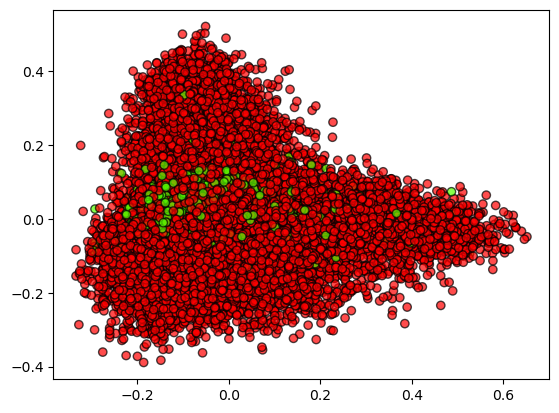

Precision score: 0.8220930232558139
Recall score: 0.7952755905511811
F1-score score: 0.808461978273299
Accuracy score: 0.9719265901282159


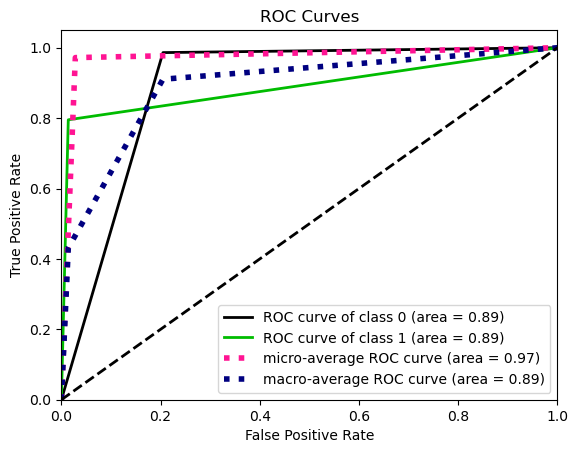

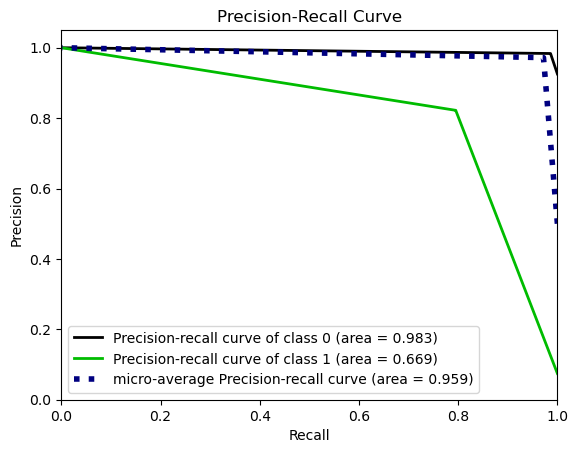

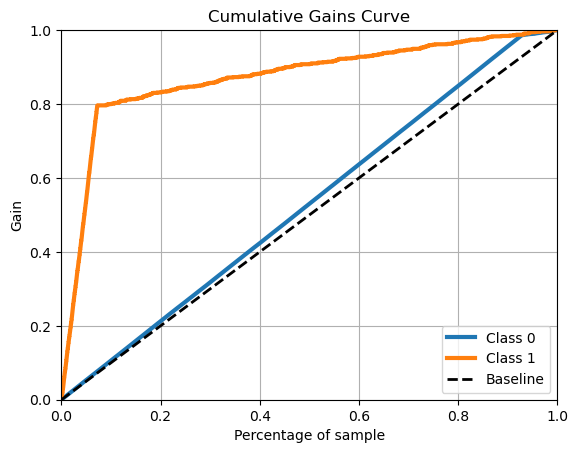

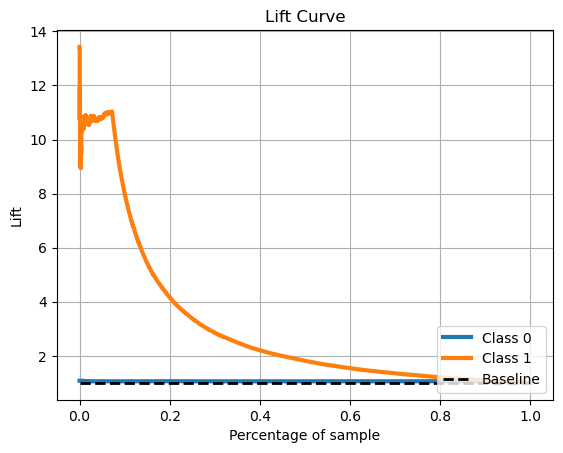

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11044
           1       0.82      0.80      0.81       889

    accuracy                           0.97     11933
   macro avg       0.90      0.89      0.90     11933
weighted avg       0.97      0.97      0.97     11933



In [6]:
roc_auc_imb, fpr_imb, tpr_imb, _ = build_and_test(X_train, X_test, y_train, y_test)

# Oversampling the smallest class

Oversampling is a technique which increases the number of samples of the smallest class up to the size of the biggest class. This is done by generating synthetic samples. Different techniques can be applied to oversample a class. In this tutorial, I would use `RandomOverSampler` and `SMOTE`. The `imbalanced-learn` package also provides other techniques, sucha as ADASYN and Rose. All over samplers provide a function, called `fit_resample()`, which receives the `X_train` input variable and the `y_train` output variable and return over sampled input and output variables, respectively `X_res` and `y_res`


In [7]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 25727})
Testing target statistics: Counter({0: 11044, 1: 889})


`X_res` and `y_res` can be provided as parameters to the `build_and_test()` function. From the PCA plot, I note that the number of green points have increased incredibly

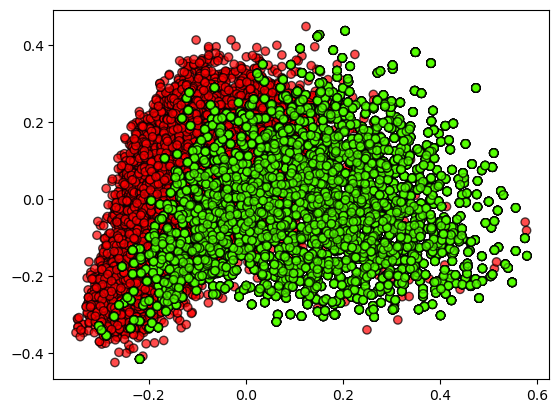

Precision score: 0.7478354978354979
Recall score: 0.7772778402699663
F1-score score: 0.7622724765581909
Accuracy score: 0.963881672672421


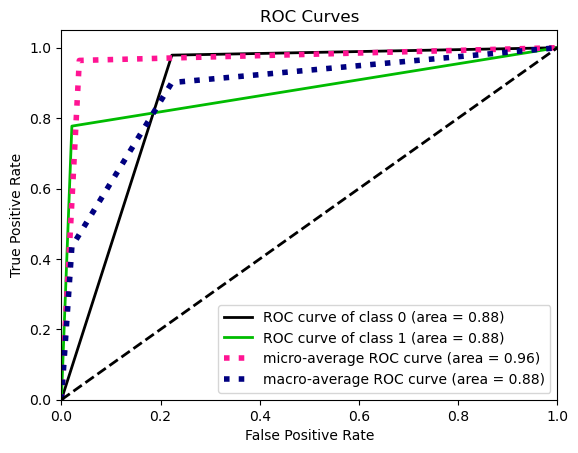

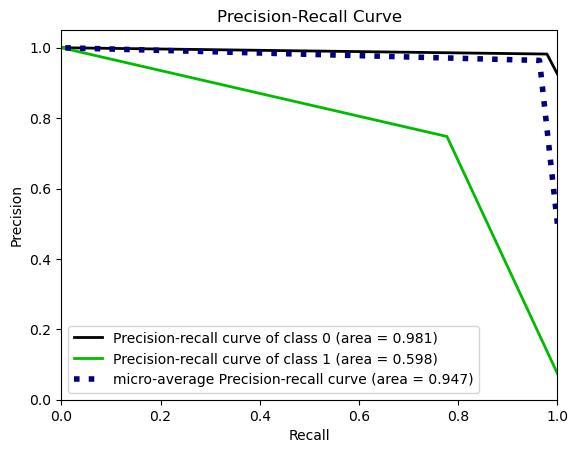

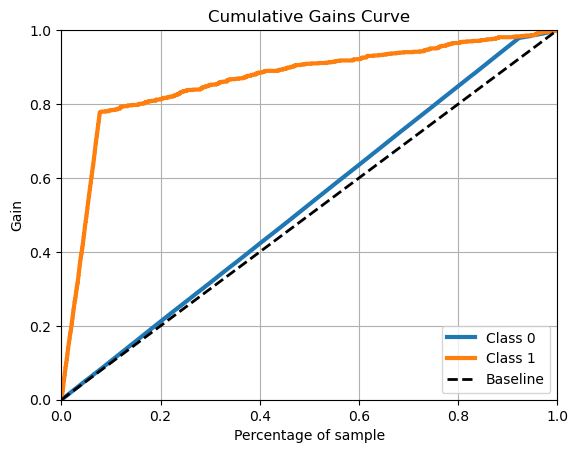

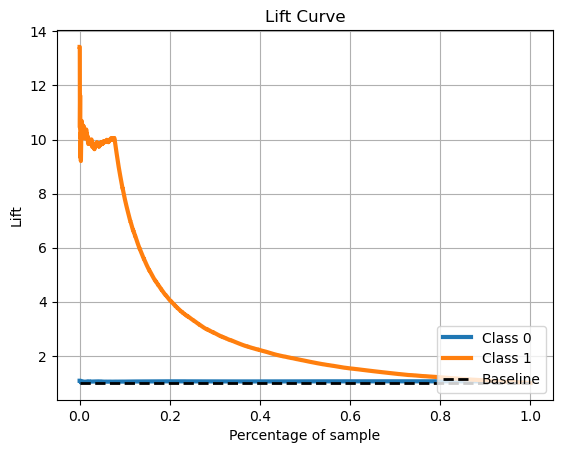

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.75      0.78      0.76       889

    accuracy                           0.96     11933
   macro avg       0.86      0.88      0.87     11933
weighted avg       0.96      0.96      0.96     11933



In [8]:
roc_auc_ros, fpr_ros, tpr_ros, _ = build_and_test(X_res, X_test, y_res, y_test)

## SMOTE

The same analysis can be done for the `SMOTE` method

In [9]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 25727})
Testing target statistics: Counter({0: 11044, 1: 889})


Similarly to `RandomOverSampler`, from the PCA plot I note the size of the green points. With respect to the `RandomOverSampler`, the distribution of the green points is quite different

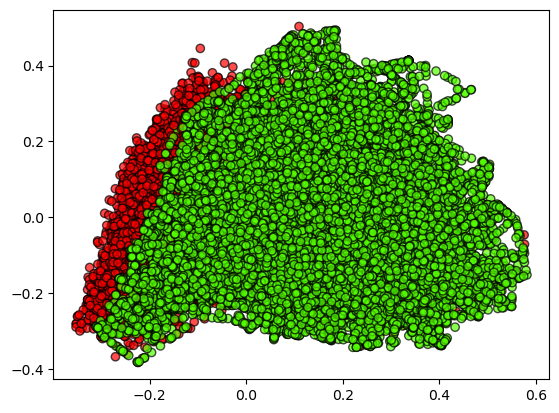

Precision score: 0.7595066803699897
Recall score: 0.8312710911136107
F1-score score: 0.7937701396348011
Accuracy score: 0.9678203301768206


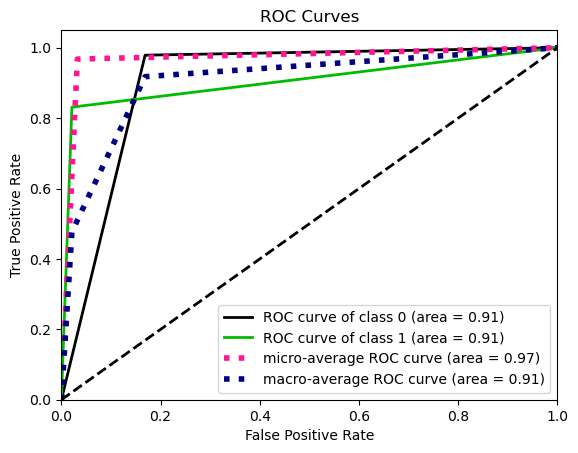

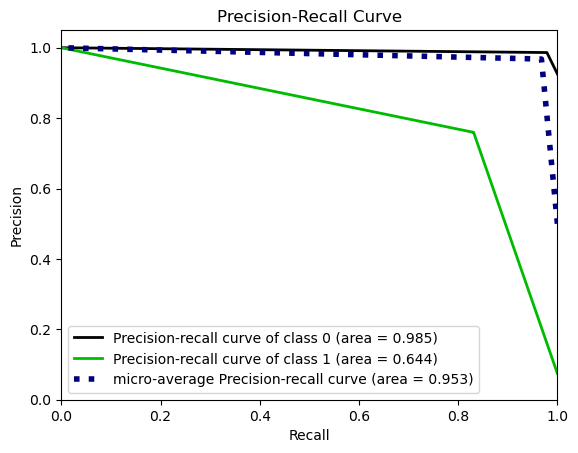

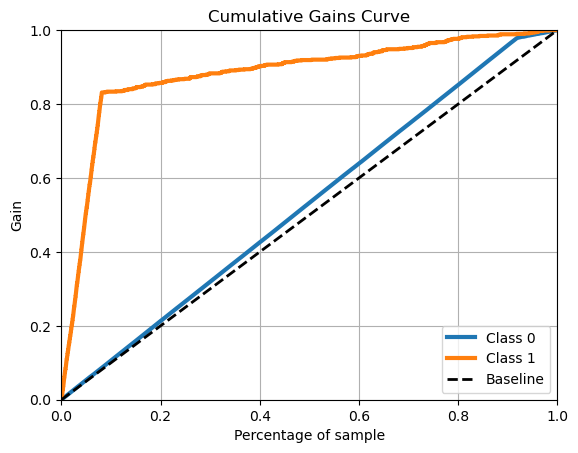

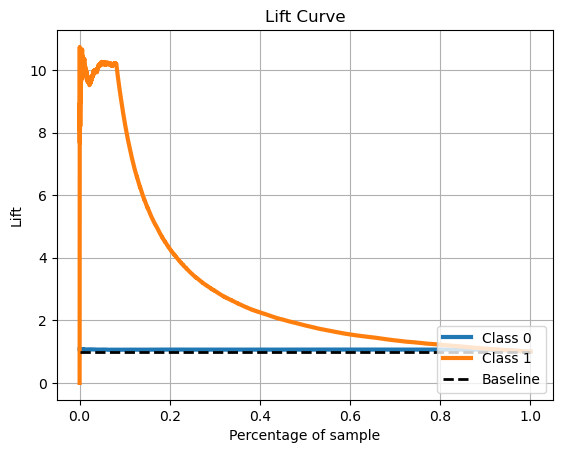

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11044
           1       0.76      0.83      0.79       889

    accuracy                           0.97     11933
   macro avg       0.87      0.91      0.89     11933
weighted avg       0.97      0.97      0.97     11933



In [10]:
roc_auc_smote, fpr_smote, tpr_smote, _ = build_and_test(X_res, X_test, y_res, y_test)

# Undersample the biggest dataset

Undersampling is a technique which decreases the number of samples of the biggest class down the size of the smallest class. This is done by removing some samples from the biggest class. Different techniques can be applied to undersample a class. In this tutorial, I will user `RandomUnderSampler` and `NearMiss`. The `imbalanced-learn` package also provides other techniques, such as Condensed Nearest Neighbour. Similarly to over samplers, all the under samplers provide a function called, `fit_resample()`, which receives the `X_train` input variable and the `y_train` output variable and return the under sampled input and output variables, respectively `X_res` and `y_res`.


In [11]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Test target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 2114, 1: 2114})
Test target statistics: Counter({0: 11044, 1: 889})


Once undersampled the dataset, I call the `build_and_test()` function. From the PCA plot, I note that the number of red points has reduced

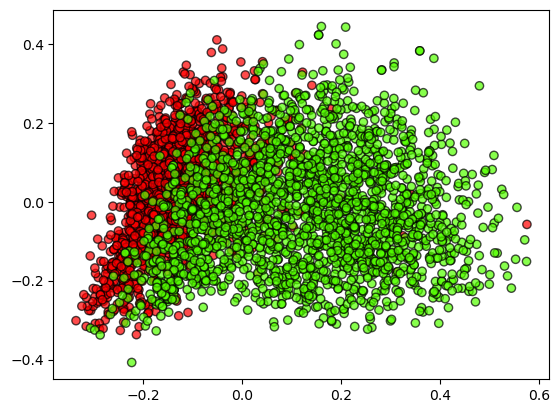

Precision score: 0.4651826484018265
Recall score: 0.9167604049493814
F1-score score: 0.617190458159788
Accuracy score: 0.9152769630436605


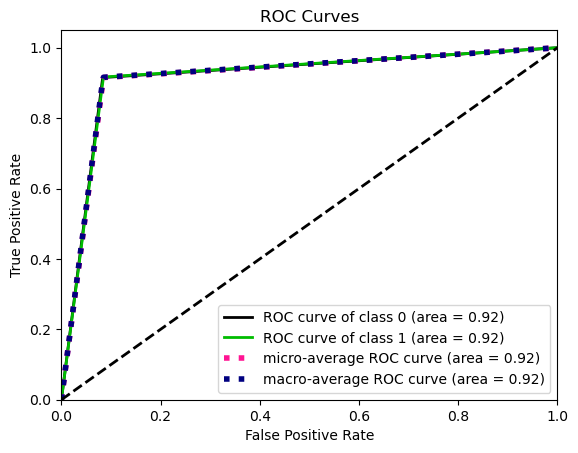

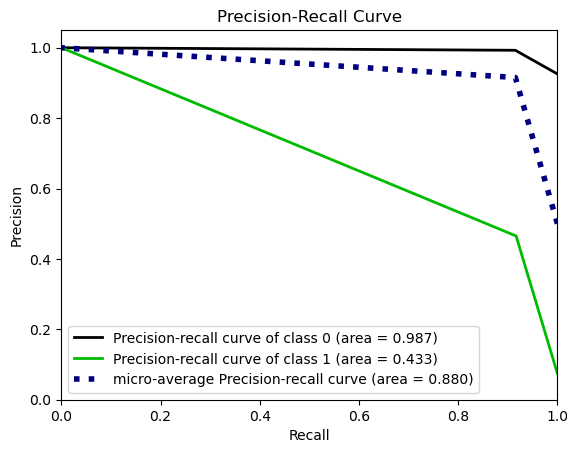

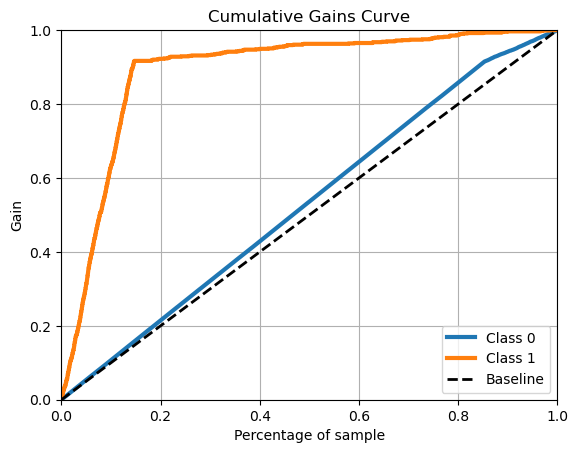

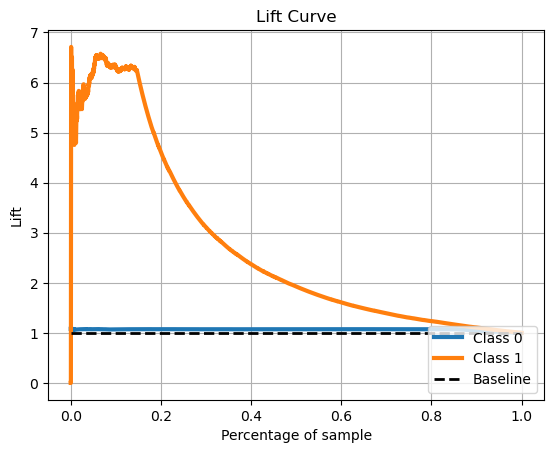

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     11044
           1       0.47      0.92      0.62       889

    accuracy                           0.92     11933
   macro avg       0.73      0.92      0.78     11933
weighted avg       0.95      0.92      0.93     11933



In [12]:
roc_auc_rus, fpr_rus, tpr_rus, _ = build_and_test(X_res, X_test, y_res, y_test)

## NearMiss

The same analysis can be done for the `NearMiss` undersampler

In [13]:
from imblearn.under_sampling import NearMiss

under_sampler = NearMiss()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Test target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 2114, 1: 2114})
Test target statistics: Counter({0: 11044, 1: 889})


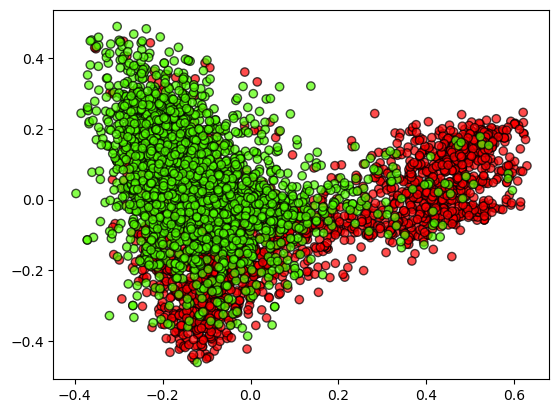

Precision score: 0.4233576642335766
Recall score: 0.8481439820022497
F1-score score: 0.5647940074906366
Accuracy score: 0.9026229782954831


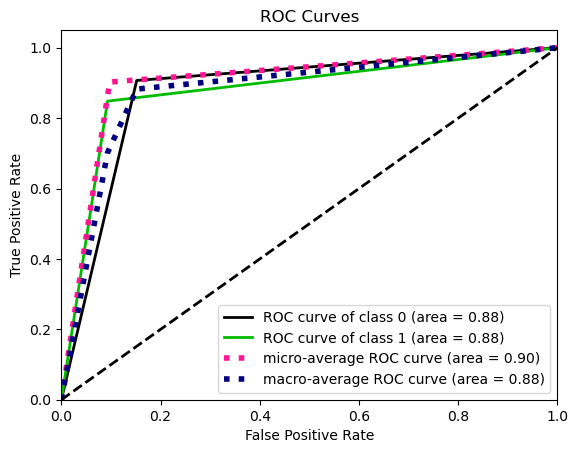

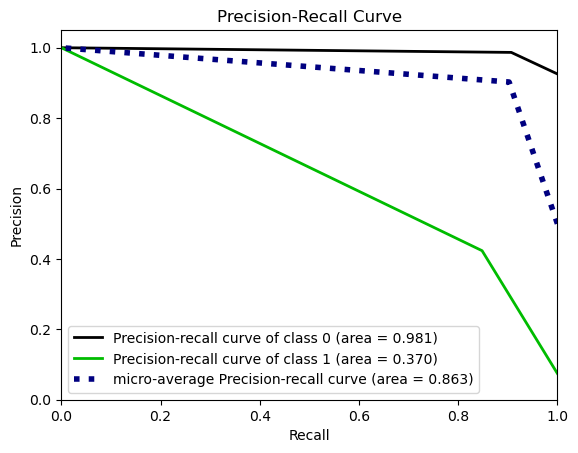

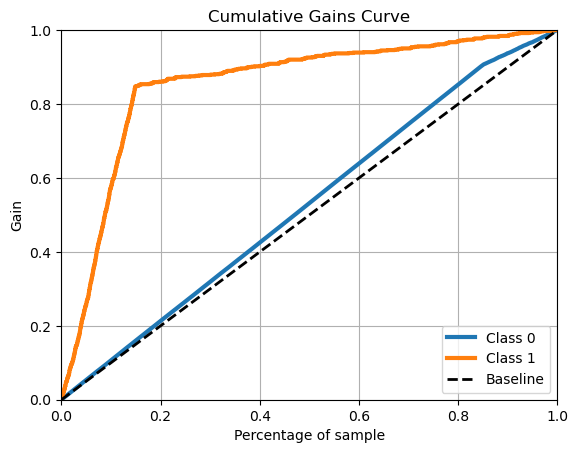

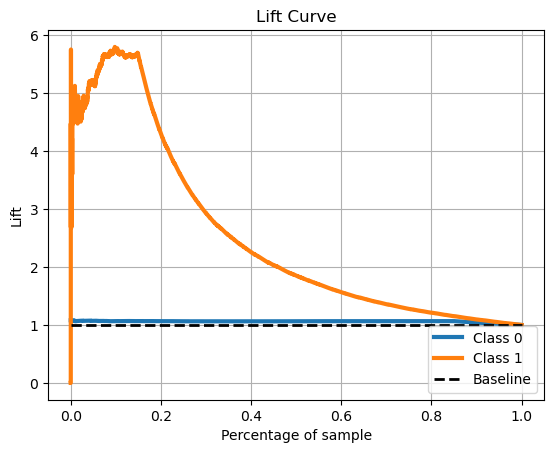

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11044
           1       0.42      0.85      0.56       889

    accuracy                           0.90     11933
   macro avg       0.71      0.88      0.75     11933
weighted avg       0.94      0.90      0.92     11933



In [14]:
roc_auc_nm, fpr_nm, tpr_nm, _ = build_and_test(X_res, X_test, y_res, y_test)

# Class Weight

Setting the class weight constitutes another valid alternative for balancing. Each `scikit-learn` classification model can be configured with a parameter, called `class_weight`, which receives the weight of each class in the form of Python dictionary. In order to calculate the weight of each class, I can set the weight of the biggest class to 1 and set the weight of the smallest class to the ratio between the number of samples of the biggest class and the number of samples of the smallest class.

In [18]:
n = Counter(y_train)
ratio = int(n[0]/n[1])
ratio, n

(12, Counter({0: 25727, 1: 2114}))

I call the `build_and_test()` function by setting the `class_weight` parameter.

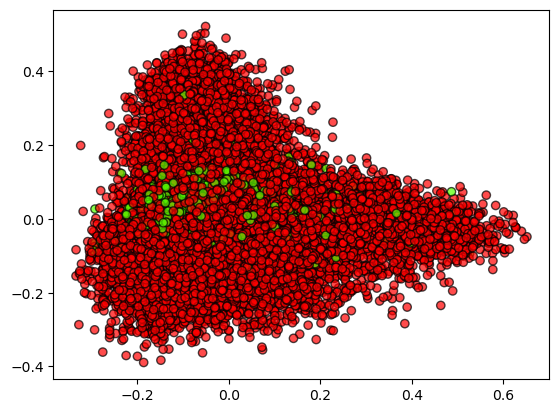

Precision score: 0.7357065803667745
Recall score: 0.7671541057367829
F1-score score: 0.7511013215859031
Accuracy score: 0.9621218469789659


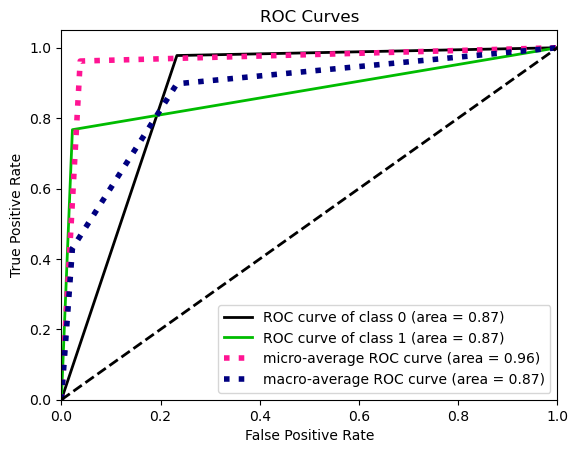

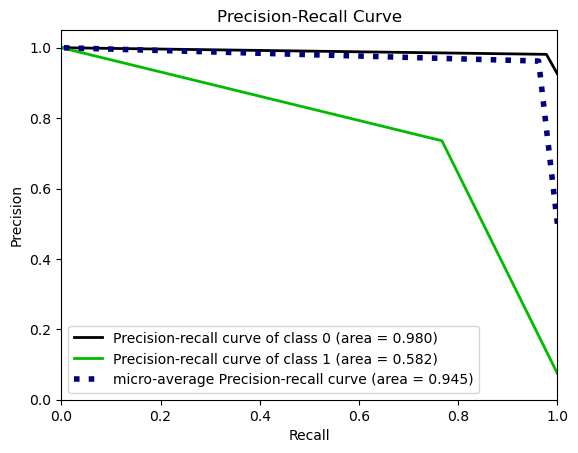

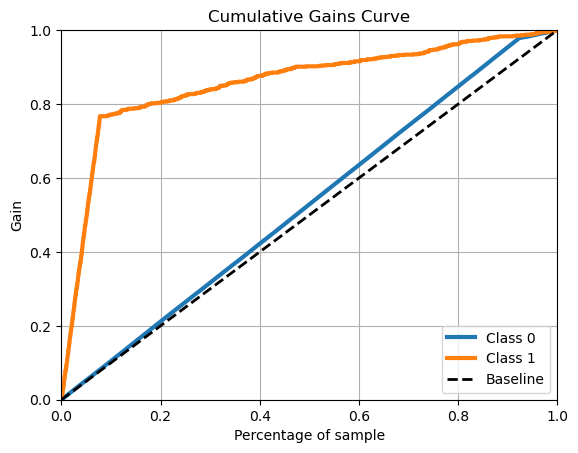

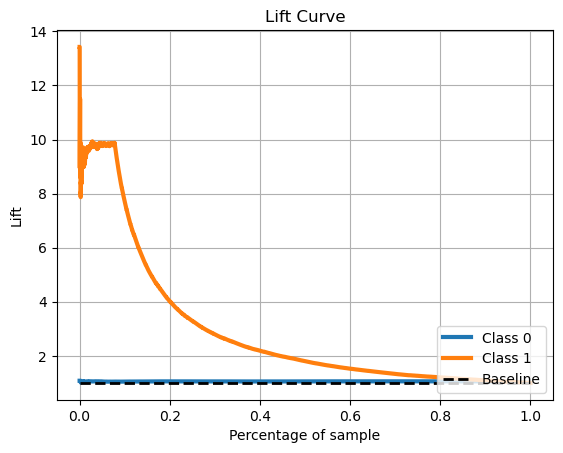

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.74      0.77      0.75       889

    accuracy                           0.96     11933
   macro avg       0.86      0.87      0.87     11933
weighted avg       0.96      0.96      0.96     11933



In [19]:
roc_auc_cw, fpr_cw, tpr_cw, _ = build_and_test(X_train, X_test, y_train, y_test, class_weight={0:1, 1:ratio})

# Threshold

Adjusting threshold is a manual technique to balance a dataset. Conceptually, if a predicted value is greater than the threshold, it is set to 1, otherwise it is set to 0. More details regarding thresholds can be found at [this link](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/). In this tutorial, I will set the value of the threshold to the value which maximises the [Youden's J statistics](https://en.wikipedia.org/wiki/Youden%27s_J_statistic). In addition, I will extract the list of candidate thresholds from the `roc_curve()`

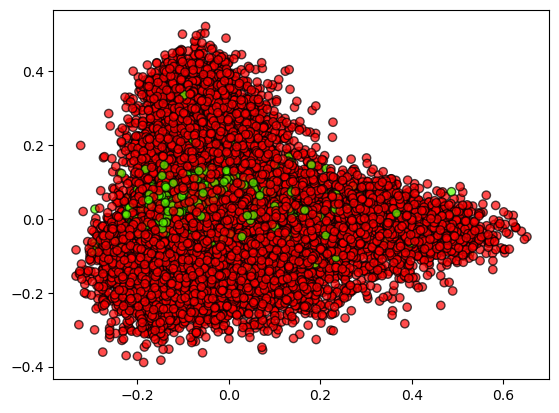

Precision score: 0.8121420389461627
Recall score: 0.7975253093363329
F1-score score: 0.8047673098751418
Accuracy score: 0.9711723791167352


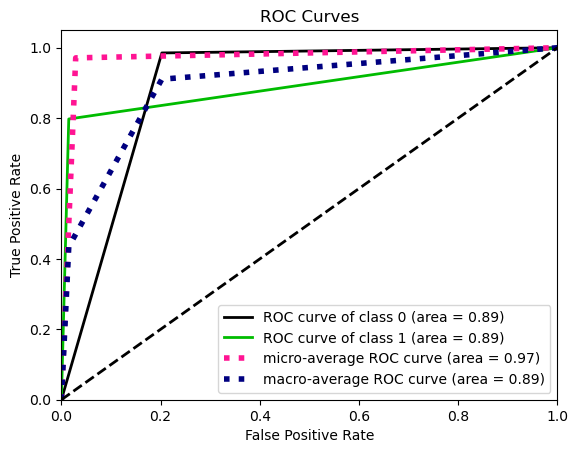

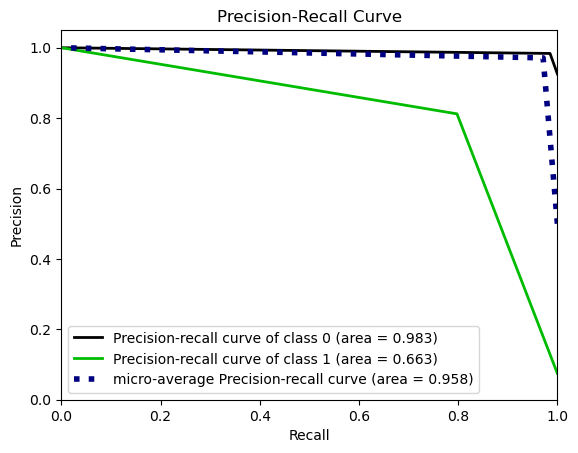

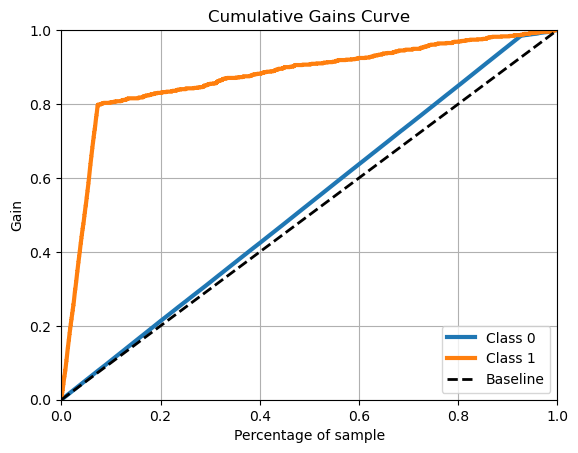

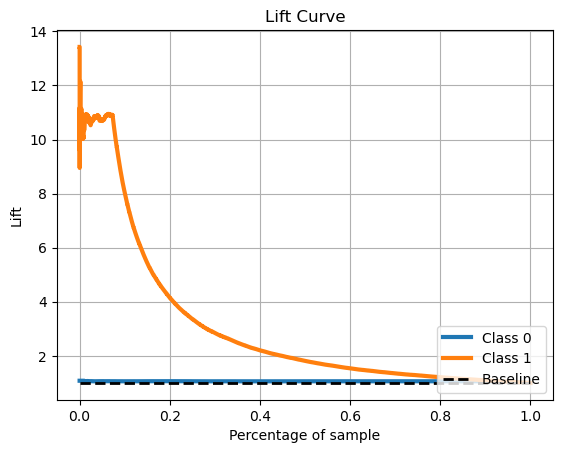

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11044
           1       0.81      0.80      0.80       889

    accuracy                           0.97     11933
   macro avg       0.90      0.89      0.89     11933
weighted avg       0.97      0.97      0.97     11933

Best Threshold: 1.0


In [22]:
roc_auc_thr, fpr_thr, tpr_thr, threshold = build_and_test(X_train, X_test, y_train, y_test, threshold=True)
print(f"Best Threshold: {threshold}")

# Plot all together

Finally, I plot all the ROC curves together, I note that in my case the best technique is the Random Under Sampler, with the greatest value of AUC

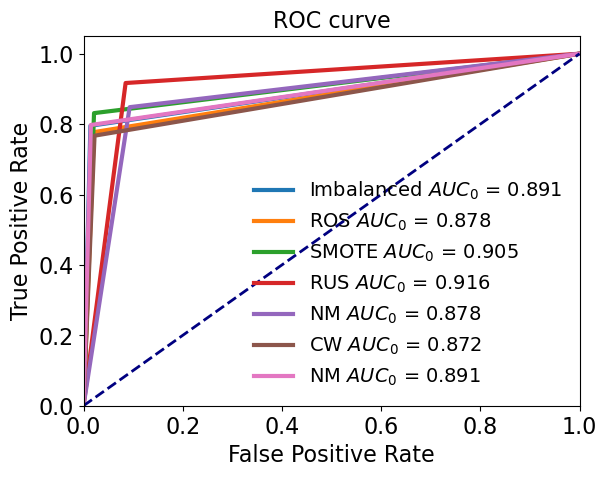

In [23]:
plt.plot(fpr_imb, tpr_imb, lw=3, label='Imbalanced $AUC_0$ = %.3f' % (roc_auc_imb))
plt.plot(fpr_ros, tpr_ros, lw=3, label='ROS $AUC_0$ = %.3f' % (roc_auc_ros))
plt.plot(fpr_smote, tpr_smote, lw=3, label='SMOTE $AUC_0$ = %.3f' % (roc_auc_smote))
plt.plot(fpr_rus, tpr_rus, lw=3, label='RUS $AUC_0$ = %.3f' % (roc_auc_rus))
plt.plot(fpr_nm, tpr_nm, lw=3, label='NM $AUC_0$ = %.3f' % (roc_auc_nm))
plt.plot(fpr_cw, tpr_cw, lw=3, label='CW $AUC_0$ = %.3f' % (roc_auc_cw))
plt.plot(fpr_thr, tpr_thr, lw=3, label='NM $AUC_0$ = %.3f' % (roc_auc_thr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()